In [169]:
#Import two moons
from sklearn.datasets import make_moons
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

In [170]:
def time_horizon(epsilon=0.002, T=80, rho=7, N=18, device='cpu'):
    """
    Compute the value of t following the formula at the bottom left page 4 of the paper.
    The horizon is flipped compared to the paper because we want to start with the largest value of t.
    epsilon is the minmum std of the noise
    T is the maximum std of the noise
    N is the number of steps
    """
    return torch.tensor([(T ** (1/rho) + (i-1)/(N-1) * (epsilon**(1/rho) - T**(1/rho)))**rho for i in range(1, N+1)]).to(device).type(torch.float32)

class MoonsDataset(Dataset):
    def __init__(self, n_samples, device, noise=0.05):
        X, _ = make_moons(n_samples=n_samples, noise=noise)
        X = torch.tensor(X, dtype=torch.float32)
        self.X = X.to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]
    
    def get_whole_dataset(self):
        return self.X

class DiffusionModel(torch.nn.Module):
    def __init__(self, dim, device, n_layers=3, n_units=256):
        super().__init__()
        self.dim = dim
        self.device = device
        self.n_layers = n_layers
        self.n_units = n_units
        self.linear1 = torch.nn.Sequential(torch.nn.Linear(dim, n_units).to(device), torch.nn.GELU())
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(n_units, n_units).to(device), torch.nn.GELU()) for _ in range(n_layers)])
        self.final_layer = torch.nn.Linear(n_units, dim).to(device)

    def time_embedding(self, t, dim, max_period=10000):
        """
        Compute the time embedding
        timesteps: a batch of times (1D tensor)
        dim: the dimension of the embedding
        """
        half_dim = dim // 2
        freqs = t[:, None] / max_period  ** (2 * torch.arange(half_dim, device=self.device) / dim)
        return torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=1).to(self.device)
        
        
    def forward(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step
        """
        time_embed = self.time_embedding(t, self.n_units).to(self.device) # Compute the time embedding
        y = self.linear1(x) # Apply the first linear layer which differs from the other layers
        
        # Apply the layers
        for layer in self.layers:
            y += time_embed # Add the time embedding to the input
            y = layer(y) # Apply the layer
        return self.final_layer(y)
    
def sampling_loop(model, device, batch_size=64, epsilon=0.002, T=80, rho=7, N=18):
    """
    Sample a gaussian noise and iteratively denoise it using the diffusion model.
    """
    x_evolution = [] # List to store the evolution of the denoising process

    Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon

    x_next = torch.randn(batch_size, 2, device=device) * Ts[0] # Sample the latents by sampling a batch of gaussian noise with the maximum std
    x_evolution.append(x_next.detach().cpu().clone()) # Append the initial latents to the list

    # Denoising loop following a simple Euler scheme
    for _, (t_cur, t_next) in list(enumerate(zip(Ts[:-1], Ts[1:]))):
        x_cur = x_next # Set the current x to the previous x
        batched_t = torch.full((batch_size,), t_cur, dtype=torch.long, device=device) # Create a batched time index
        predicted_x_0_from_x_t = model(x_cur, batched_t) # Predict the denoised image using the model. The time is passed through the index
        euler_step_direction = (predicted_x_0_from_x_t - x_cur) / t_cur # Compute the direction of the Euler step
        x_next = x_cur + (t_cur - t_next) * euler_step_direction # Take an euler step of length t_next - t_cur in the direction euler_step_direction
        
        x_evolution.append(x_next.detach().cpu().clone()) #Append a copy of x_next that is sent to the cpu deatched etc 

    return x_evolution

def load_diffusion_model(path, n_units, device):
    """
    Load a diffusion model from a file
    """
    model = DiffusionModel(2, device, n_units=n_units)
    model.load_state_dict(torch.load(path))
    return model

In [171]:
def ema_decay_rate_schedule(N, s0=2, mu0=0.9):
    """
    Compute the exponential moving average decay rate following the formula p26
    """
    return np.exp(s0 * np.log(mu0) / N)

class ConsistencyModel(torch.nn.Module):
    def __init__(self, dim, device, epsilon=0.002, sigma_data=0.5, n_layers=3, n_units=256):
        super().__init__()
        self.epsilon = epsilon
        self.sigma_data = sigma_data
        self.dim = dim
        self.device = device
        self.n_layers = n_layers
        self.n_units = n_units
        self.linear1 = torch.nn.Sequential(torch.nn.Linear(dim, n_units).to(device), torch.nn.GELU())
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(n_units, n_units).to(device), torch.nn.GELU()) for _ in range(n_layers)])
        self.final_layer = torch.nn.Linear(n_units, dim).to(device)

    
    def c_skip(self, t):
        return (self.sigma_data ** 2 / ((t - self.epsilon) ** 2 + self.sigma_data ** 2))[:, None]

    def c_out(self, t):
        return (self.sigma_data * (t - self.epsilon) / (self.sigma_data ** 2 + t **2) ** 0.5)[:, None]

    def time_embedding(self, t, dim, max_period=10000):
        """
        Compute the time embedding
        timesteps: a batch of times (1D tensor)
        dim: the dimension of the embedding
        """
        half_dim = dim // 2
        freqs = t[:, None] / max_period  ** (2 * torch.arange(half_dim, device=self.device) / dim)
        return torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=1).to(self.device)
        
    
    def F(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step index
        """
        time_embed = self.time_embedding(t, self.n_units).to(self.device) # Compute the time embedding
        y = self.linear1(x) # Apply the first linear layer which differs from the other layers
        
        # Apply the layers
        for layer in self.layers:
            y += time_embed # Add the time embedding to the input
            y = layer(y) # Apply the layer
        return self.final_layer(y)

    def forward(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step index
        The formula is from the right column of p3 of the original paper. 
        """
        return self.c_skip(t) * x + self.c_out(t) * self.F(x, t)
   
def consistency_distillation_loop(consistency_target_model, diffusion_model, dataloader, device, lr = 1e-3, n_epochs=2000, epsilon=0.002, T=80, rho=7, N=18, ema=True):
    print(f"Training the consistency model with the following parameters: n_epochs={n_epochs}, lr={lr}, epsilon={epsilon}, T={T}, rho={rho}, ema={ema}")

    if ema:
        consistency_online_model = copy.deepcopy(consistency_target_model).to(device)
    else:
        consistency_online_model = consistency_target_model
    optimizer = torch.optim.Adam(consistency_online_model.parameters(), lr=lr)

    batch_size = dataloader.batch_size

    Ts = time_horizon(epsilon, T, rho, N, device).flip(0) # Compute the time horizon with index 0 corresponding to the smallest time and index N-1 to the largest time
    mu = ema_decay_rate_schedule(N) # Compute the exponential moving average decay rate following the schedule
    losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for X in dataloader:
            optimizer.zero_grad() # Zero the gradients
            n = torch.randint(0, N-1, (batch_size,)) # Sample random time steps in the time horizon
            tiled_Ts_n = Ts[n][:, None].repeat(1, 2) # Tile the time steps to match the shape of the predicted_x_0_from_x_n_plus_1
            tiled_Ts_n_plus_1 = Ts[n+1][:, None].repeat(1, 2) # Tile the time steps to match the shape of the predicted_x_0_from_x_n_plus_1
            
            z = torch.randn_like(X) # Sample random noise latents
            x_n_plus_1 = X + z * Ts[n+1][:, None] # Compute the noisy latents at time t_{n+1}

            # Perform a reverse diffusion step on x_n_plus_1 to get x_n
            predicted_x_0_from_x_n_plus_1 = diffusion_model(x_n_plus_1, Ts[n+1]) # Predict the denoised data using the model.
            euler_step_direction = (predicted_x_0_from_x_n_plus_1 - x_n_plus_1) / tiled_Ts_n # Compute the direction of the Euler step
            x_n_phi = x_n_plus_1 - (tiled_Ts_n - tiled_Ts_n_plus_1) * euler_step_direction # Take an euler step of length Ts[n] - Ts[n+1] in the direction euler_step_direction

            loss = torch.nn.functional.mse_loss(consistency_online_model(x_n_plus_1, Ts[n+1]), consistency_target_model(x_n_phi, Ts[n]))
            loss.backward() # Backward pass
            optimizer.step() # Optimize the model
            running_loss += loss.item() # Add the loss to the running loss

            for online_p, target_p in zip(consistency_online_model.parameters(), consistency_target_model.parameters()): # Update the online model using the exponential moving average
                target_p.data = mu * target_p.data + (1 - mu) * online_p.data
                
        losses.append(running_loss / len(dataloader)) # Append the average loss to the losses list
        if (epoch+1) % 25 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss / len(dataloader):.4f}")
    
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(MSE)")
    plt.show()

def consistency_single_step_sampling(model, device, batch_size=64, T=80):
    """
    Sample a gaussian noise and denoise it in a single step using the consistency model.
    """
    z = torch.randn(batch_size, 2, device=device) * T # Sample the latents by sampling a batch of gaussian noise with the maximum std
    batched_T = torch.full((batch_size,), T, device=device) # Create a batched time index
    denoised_x = model(z, batched_T) # Denoise the latents using the consistency model
    return denoised_x.detach().cpu().clone()

def consistency_multiple_step_sampling(model, device, batch_size=64, times = [80, 0.002], epsilon=0.002):
    """
    Multistep Consistency Sampling from Algorithm 1 in the left column of p4 of the paper
    """
    x_evolution = [] # List to store the evolution of the denoising process

    z = torch.randn(batch_size, 2, device=device) # Sample the latents by sampling a batch of gaussian noise with the maximum std
    x_noisy = z * times[0] # Initialize the noisy latents as the sampled latents scaled by the maximum std
    batched_T = torch.full((batch_size,), times[0], device=device) # Create a batched time
    x = model(x_noisy, batched_T) # Denoise the latents using the consistency model
    x_evolution.append(x.detach().cpu().clone()) # Append the denoised latents to the list

    for t in times[1:]:
        z = torch.randn(batch_size, 2, device=device) # Sample noise
        x_noisy = x + z * (t**2 - epsilon**2)**0.5 # Add noise to the previous x
        batched_t = torch.full((batch_size,), t, device=device) # Create a batched time index
        x = model(x_noisy, batched_t) # Denoise the latents using the consistency model
        x_evolution.append(x.detach().cpu().clone()) # Append the denoised latents to the list

    return x_evolution

In [172]:
dataset_size = 16384
training_batch_size = 512
training_iterations = 10000
n_epochs = training_iterations // (dataset_size // training_batch_size)
epsilon = 0.002
T = 80
rho = 7
N = 18
n_units = 256
n_layers = 3
dim = 2
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

Training the consistency model with the following parameters: n_epochs=312, lr=0.001, epsilon=0.002, T=5, rho=7, ema=False
Epoch 25/312 - Loss: 0.0002
Epoch 50/312 - Loss: 0.0002
Epoch 75/312 - Loss: 0.0001
Epoch 100/312 - Loss: 0.0001
Epoch 125/312 - Loss: 0.0001
Epoch 150/312 - Loss: 0.0001
Epoch 175/312 - Loss: 0.0001
Epoch 200/312 - Loss: 0.0001
Epoch 225/312 - Loss: 0.0001
Epoch 250/312 - Loss: 0.0001
Epoch 275/312 - Loss: 0.0000
Epoch 300/312 - Loss: 0.0000


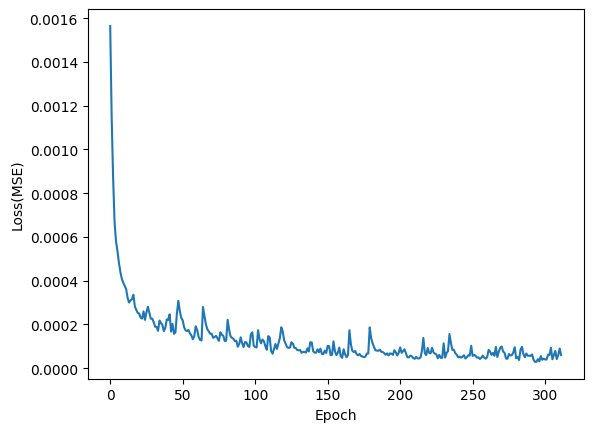

In [173]:
# Create the dataset
dataset = MoonsDataset(dataset_size, device)
dataloader = DataLoader(dataset, batch_size=training_batch_size, shuffle=True)

# Load the distilled diffusion model
diffusion_model = load_diffusion_model("diffusion_model.pt", n_units, device)

# Create the model
model = ConsistencyModel(dim, device, epsilon=epsilon, n_units=n_units, n_layers=n_layers).to(device)

# Train the model
losses = consistency_distillation_loop(model, diffusion_model, dataloader, device, lr=learning_rate, n_epochs=n_epochs, epsilon=epsilon, T=T, rho=rho, ema=False)

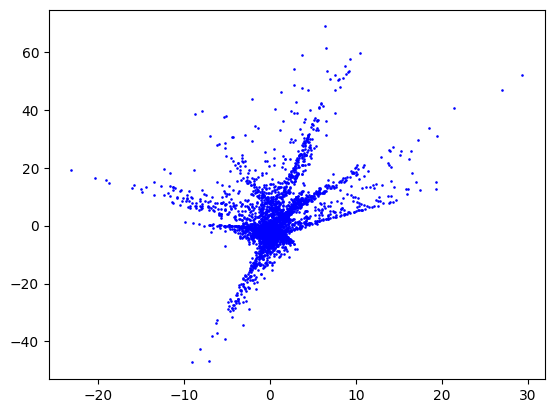

In [174]:
x_singlestep = consistency_single_step_sampling(model, device, batch_size=4096)

plt.scatter(x_singlestep[:,0], x_singlestep[:,1], s=0.75, c='b')

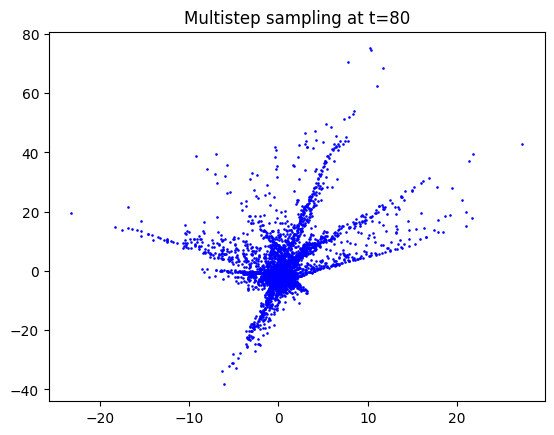

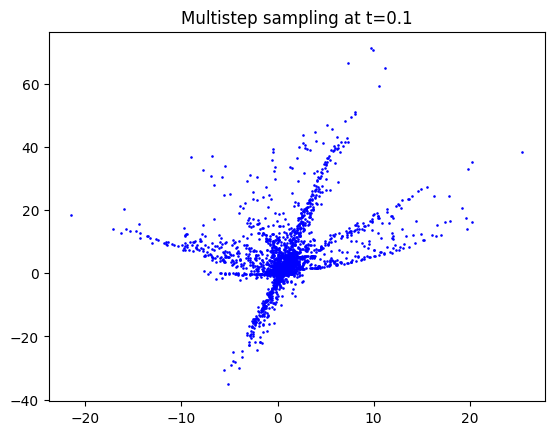

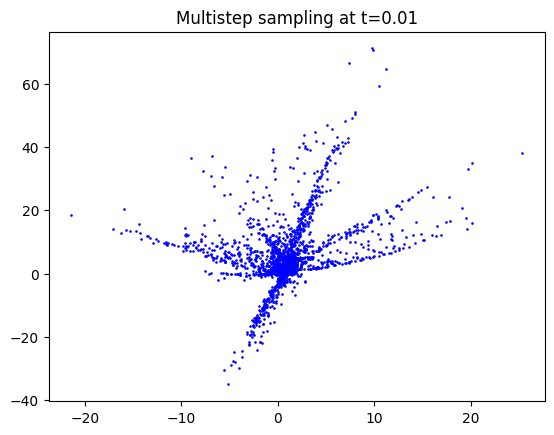

In [175]:
times = [80, 0.1, 0.01]
x_multistep_sampling = consistency_multiple_step_sampling(model, device, batch_size=4096, times=times)

for i, x in enumerate(x_multistep_sampling):
    plt.scatter(x[:, 0], x[:, 1], s=0.75, c='b')
    plt.title(f"Multistep sampling at t={times[i]}")
    plt.show()

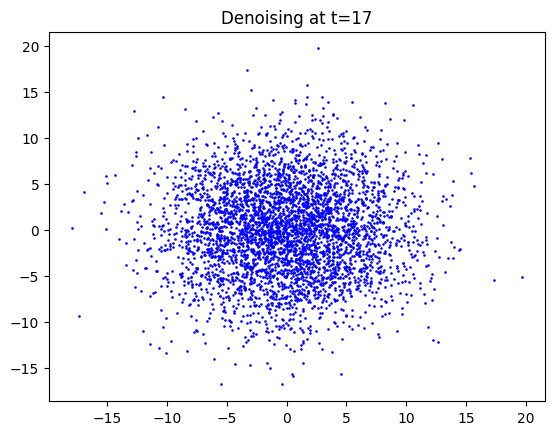

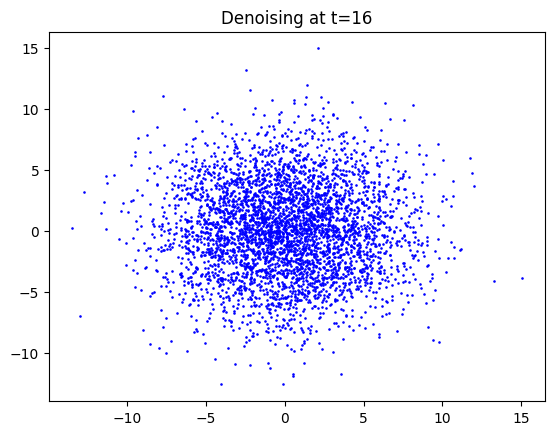

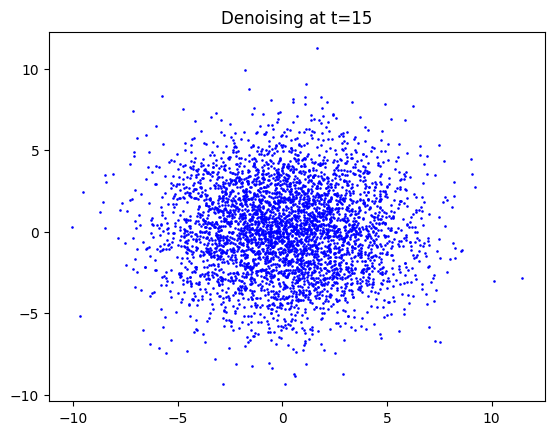

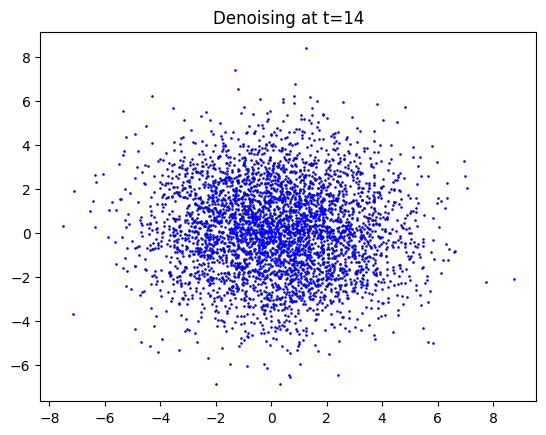

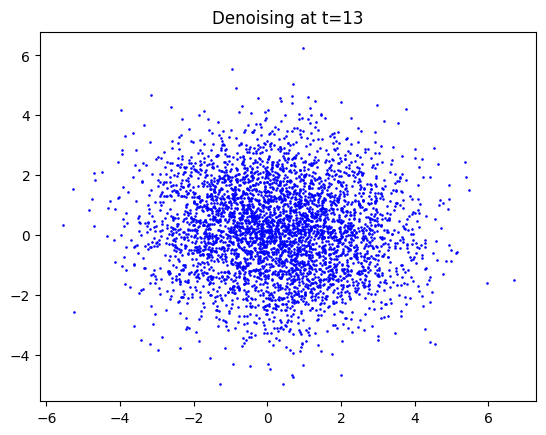

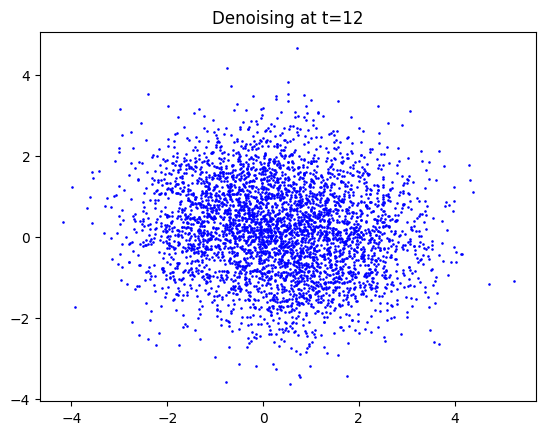

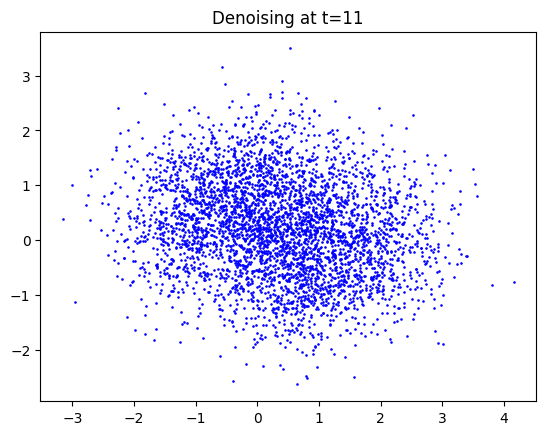

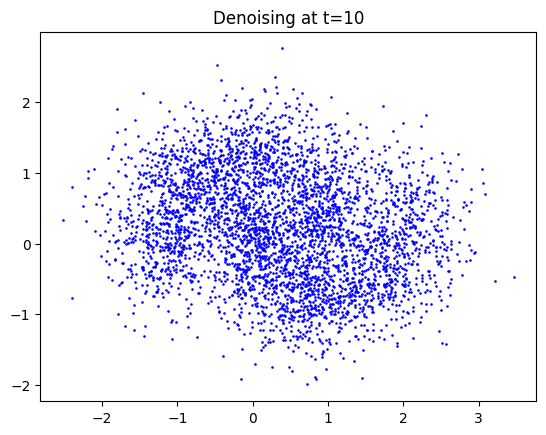

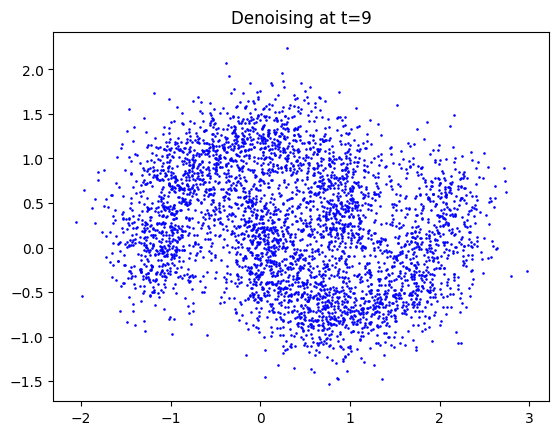

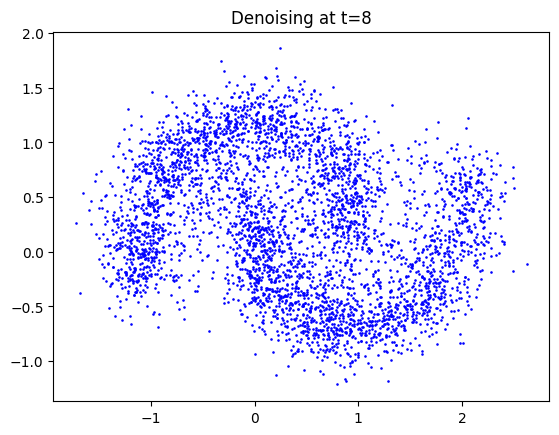

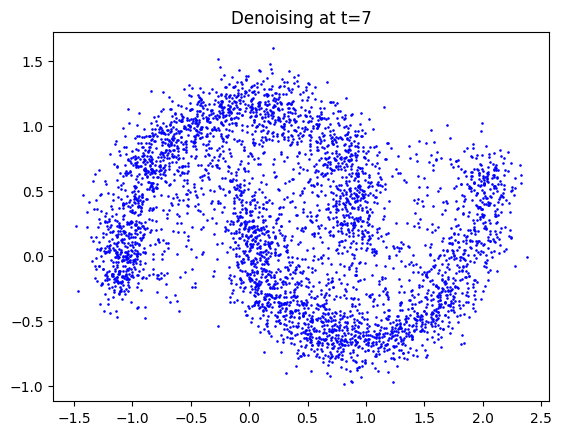

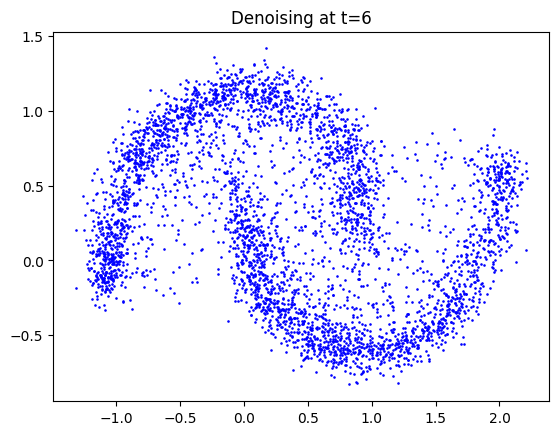

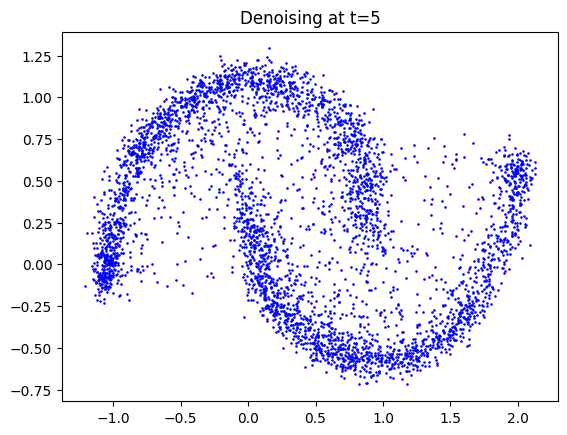

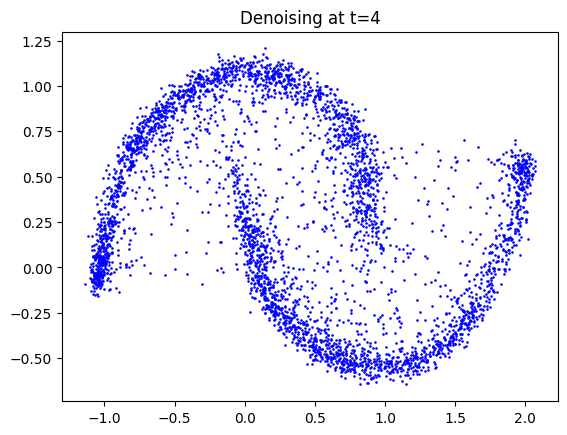

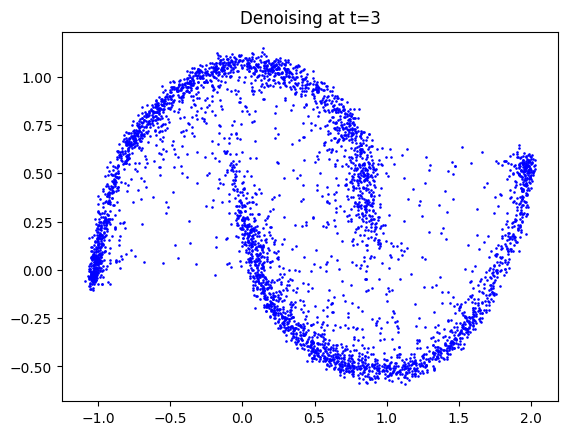

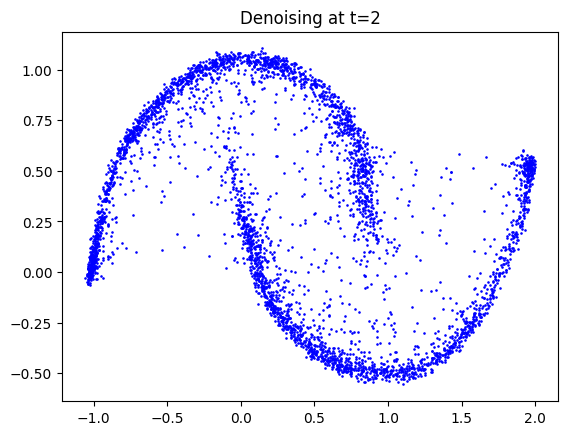

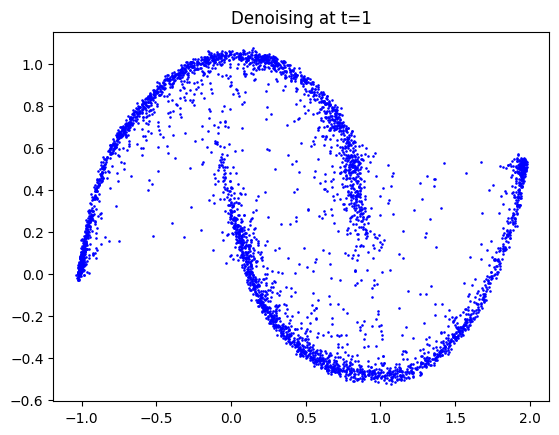

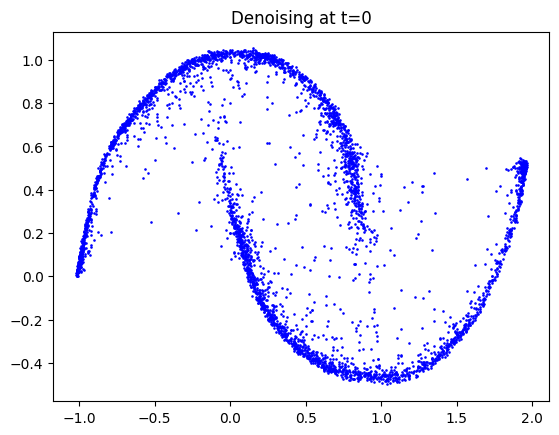

In [176]:
def sampling_loop(model, device, batch_size=64, epsilon=0.002, T=80, rho=7, N=18):
    """
    Sample a gaussian noise and iteratively denoise it using the diffusion model.
    """
    x_evolution = [] # List to store the evolution of the denoising process

    Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon

    x_next = torch.randn(batch_size, 2, device=device) * Ts[0] # Sample the latents by sampling a batch of gaussian noise with the maximum std
    x_evolution.append(x_next.detach().cpu().clone()) # Append the initial latents to the list

    # Denoising loop following a simple Euler scheme
    for _, (t_cur, t_next) in list(enumerate(zip(Ts[:-1], Ts[1:]))):
        x_cur = x_next # Set the current x to the previous x
        batched_t = torch.full((batch_size,), t_cur, dtype=torch.long, device=device) # Create a batched time
        predicted_x_0_from_x_t = model(x_cur, batched_t) # Predict the denoised data using the model.
        euler_step_direction = (predicted_x_0_from_x_t - x_cur) / t_cur # Compute the direction of the Euler step
        x_next = x_cur + (t_cur - t_next) * euler_step_direction # Take an euler step of length t_next - t_cur in the direction euler_step_direction
        
        x_evolution.append(x_next.detach().cpu().clone()) #Append a copy of x_next that is sent to the cpu deatched etc 

    return x_evolution

x_evolution = sampling_loop(diffusion_model, device, batch_size=4096, epsilon=epsilon, T=T, rho=rho, N=N)

for i, x in enumerate(x_evolution):
    plt.scatter(x[:, 0], x[:, 1], s=0.75, c='b')
    plt.title(f"Denoising at t={N-i-1}")
    plt.show()